In [1]:
import inox
import inox.nn as nn
import jax
import jax.numpy as jnp
import optax

from inox.random import PRNG, set_rng
from typing import *

from priors.nn import *
from priors.score import *

from utils import *

In [2]:
rng = PRNG(0)

## Data

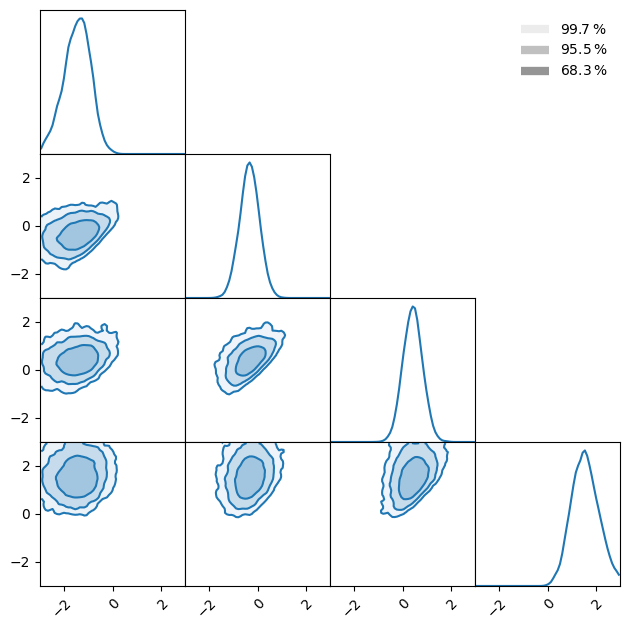

In [3]:
n = 8192
x = generate(n, key=rng.split())
fig = show(x)

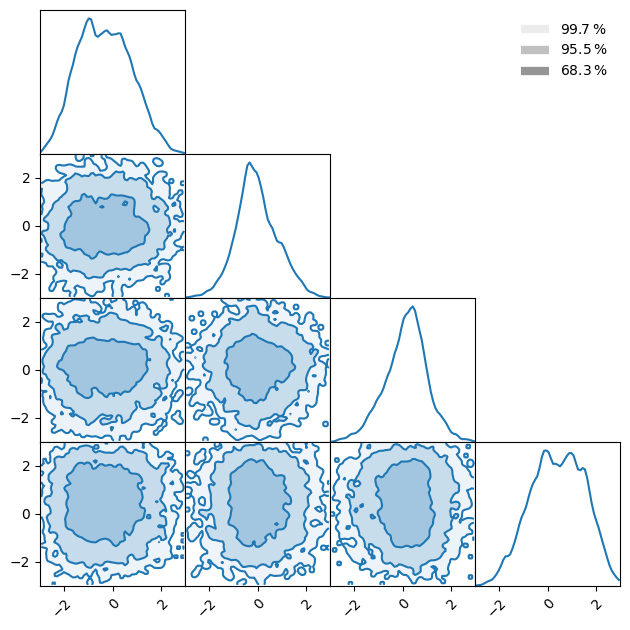

In [4]:
def measure(A, x):
    return A * x

A = rng.uniform(x.shape) < 0.25
y = measure(A, x) + 1e-3 * rng.normal((n, 10))

def sample(model, A, y):
    sampler = Euler(
        PosteriorScoreModel(
            model=model,
            A=inox.Partial(measure, A),
            y=y,
            noise=1e-3,
            gamma=1.0,
        ),
    )

    z = rng.normal((n, 10))

    return sampler(z, steps=64)

x_bis = sample(StandardScoreModel(), A, y)
fig = show(x_bis)

## Training

In [5]:
def train(x, A, y):
    model = make_model(key=rng.split())
    static, params, others = model.partition(nn.Parameter)

    scheduler = optax.linear_schedule(init_value=1e-3, end_value=1e-6, transition_steps=8192)
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    objective = MeasureLoss()

    @jax.jit
    def sgd_step(params, others, opt_state, x, A, key):
        def ell(params):
            model = static(params, others)

            z = jax.random.normal(key, x.shape)
            t = jax.random.uniform(key, x.shape[:1])

            return objective(model, x, z, t, inox.Partial(measure, A))

        loss, grads = jax.value_and_grad(ell)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return loss, params, opt_state

    for step in range(8192):
        i = rng.randint(shape=(256,), minval=0, maxval=len(y))

        loss, params, opt_state = sgd_step(params, others, opt_state, x[i], A[i], rng.split())

        if step % 1024 == 0:
            print(f'({step})', float(loss))

    return static(params, others)

(0) 0.1584143042564392
(1024) 0.07582929730415344
(2048) 0.09513598680496216
(3072) 0.07463036477565765
(4096) 0.08564451336860657
(5120) 0.07610179483890533
(6144) 0.0631234422326088
(7168) 0.08144726604223251


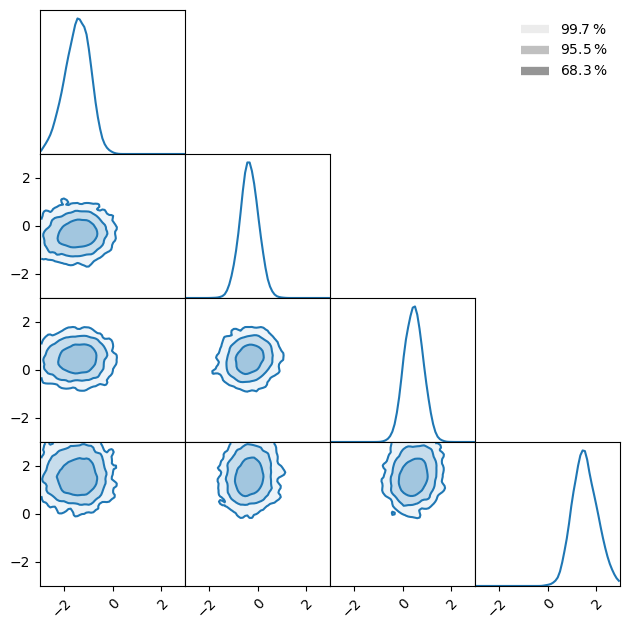

In [6]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = show(x_bis)

(0) 0.18365240097045898
(1024) 0.07224322855472565
(2048) 0.07110638916492462
(3072) 0.07557888329029083
(4096) 0.06857997924089432
(5120) 0.07698777318000793
(6144) 0.0850055068731308
(7168) 0.08114168792963028


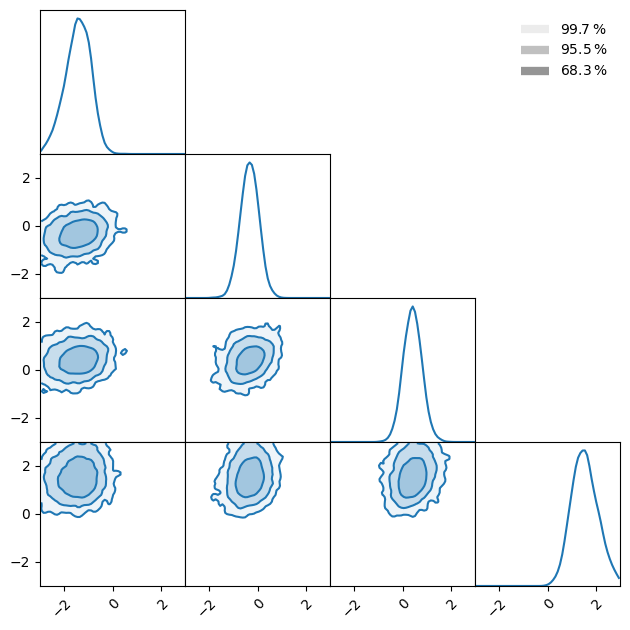

In [7]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = show(x_bis)

(0) 0.17281809449195862
(1024) 0.07066100835800171
(2048) 0.06685243546962738
(3072) 0.07855649292469025
(4096) 0.07926268875598907
(5120) 0.06885649263858795
(6144) 0.0741431936621666
(7168) 0.06792870163917542


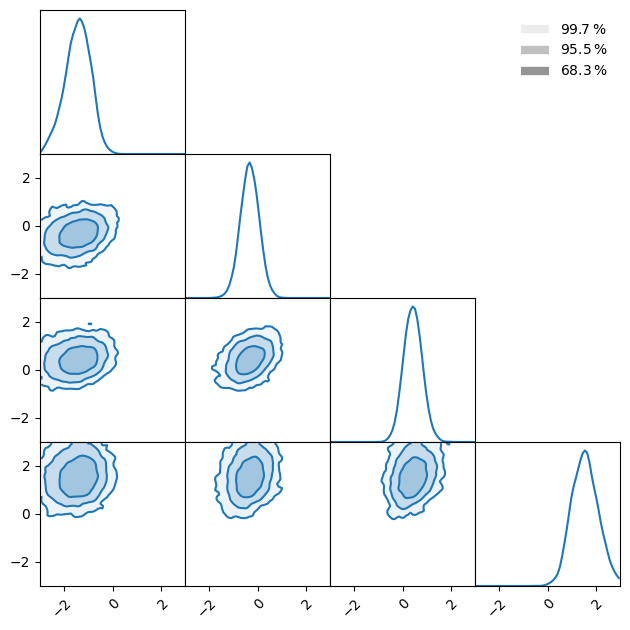

In [8]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = show(x_bis)

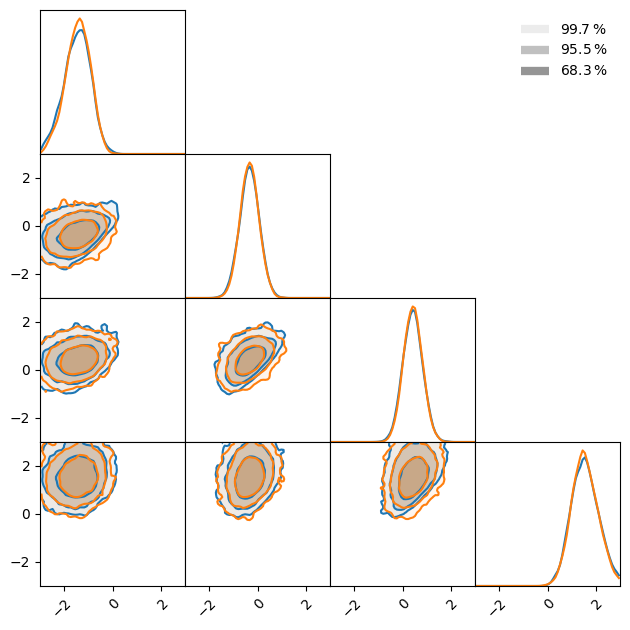

In [9]:
sampler = Euler(model)
x_ter = sampler(rng.normal((n, 10)), steps=64)

fig = show(x)
fig = show(x_ter, figure=fig)